In [2]:
#%%
!pip3 install albumentations


Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm, trange


In [4]:
#%%
class carlaData(Dataset):
    def __init__(self,img_dir,transform = None):
        self.transforms = transform
        image_paths = [i+'/CameraRGB' for i in img_dir]
        seg_paths = [i+'/CameraSeg' for i in img_dir]
        self.images,self.masks = [],[]
        for i in image_paths:
            imgs = os.listdir(i)
            self.images.extend([i+'/'+img for img in imgs])
        for i in seg_paths:
            masks = os.listdir(i)
            self.masks.extend([i+'/'+mask for mask in masks])
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img = np.array(Image.open(self.images[index]))
        mask = np.array(Image.open(self.masks[index]))
        if self.transforms is not None:
            aug = self.transforms(image=img,mask=mask)
            img = aug['image']
            mask = aug['mask']
            mask = torch.max(mask,dim=2)[0]
        return img,mask
#%%


In [5]:
data_dir = ['archive' + '/data'+i+'/data'+i for i in ['A','B','C','D','E']]
#%%
t1 = A.Compose([
    A.Resize(128,128),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])
#%%

def get_images(image_dir,transform = None,batch_size=1,shuffle=True,pin_memory=True):
    data = carlaData(image_dir,transform = t1)
    train_size = int(0.8 * data.__len__())
    test_size = data.__len__() - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
    train_batch = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    test_batch = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    return train_batch,test_batch
#%%
train_batch,test_batch = get_images(data_dir,transform =t1,batch_size=1)
#%%
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim//8, kernel_size = 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim//8, kernel_size = 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim, kernel_size = 1)

        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        m_batchsize, C, width, height = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim = -1)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, width, height)

        out = self.gamma*out + x
        return out, attention


In [6]:
#%%
device = "cuda" if torch.cuda.is_available() else "cpu"
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            
            nn.Conv2d(in_channels, out_channels,3,1,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels,out_channels,3,1,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
            
        )
    
    def forward(self,x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self,in_channels=3, out_channels=23,features=[64,128,256,512]):
        super(UNET,self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        # Downsampling
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        
        # Upsampling
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
        
        self.bottleneck = DoubleConv(features[-1],features[-1]*2)    
        self.final_conv = nn.Conv2d(features[0],out_channels, kernel_size=1)
        
    def forward(self, x):
        
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)    
        skip_connections = skip_connections[::-1]
        
        for idx in range(0,len(self.ups),2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x.TF.resize(x,size = skip_connection.shape[2:])
                
            concat_skip = torch.cat((skip_connection,x),dim=1)
            x = self.ups[idx+1](concat_skip)
        
        return self.final_conv(x)


In [32]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#%%
model = UNET().to(DEVICE)
LEARNING_RATE = 1e-4
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()
#%%
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_batch),total=len(train_batch))
    print("EPOCH - ",epoch+1)
    for batch_idx, (data, targets) in loop:
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        targets = targets.type(torch.long)
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())
    

torch.save(model,'./model/unet.pt')

  0%|          | 2/4000 [00:00<04:55, 13.51it/s, loss=3.15]

EPOCH -  1


  0%|          | 2/4000 [00:00<04:39, 14.29it/s, loss=0.655]

EPOCH -  2


  0%|          | 2/4000 [00:00<04:19, 15.43it/s, loss=0.55] 

EPOCH -  3


  0%|          | 2/4000 [00:00<04:36, 14.44it/s, loss=0.461]

EPOCH -  4


  0%|          | 2/4000 [00:00<04:24, 15.12it/s, loss=0.815]

EPOCH -  5


  0%|          | 2/4000 [00:00<04:17, 15.54it/s, loss=0.654]

EPOCH -  6


  0%|          | 2/4000 [00:00<04:03, 16.39it/s, loss=0.839]

EPOCH -  7


  0%|          | 2/4000 [00:00<04:20, 15.36it/s, loss=0.829]

EPOCH -  8


  0%|          | 2/4000 [00:00<05:04, 13.13it/s, loss=0.706]

EPOCH -  9


  0%|          | 2/4000 [00:00<04:15, 15.63it/s, loss=0.478]

EPOCH -  10


  0%|          | 2/4000 [00:00<04:25, 15.08it/s, loss=0.607]

EPOCH -  11


  0%|          | 2/4000 [00:00<04:13, 15.79it/s, loss=0.728]

EPOCH -  12


  0%|          | 2/4000 [00:00<04:10, 15.97it/s, loss=0.954]

EPOCH -  13


  0%|          | 2/4000 [00:00<04:10, 15.95it/s, loss=0.793]

EPOCH -  14


  0%|          | 2/4000 [00:00<04:40, 14.24it/s, loss=0.676]

EPOCH -  15


  0%|          | 2/4000 [00:00<04:33, 14.64it/s, loss=0.541]

EPOCH -  16


  0%|          | 2/4000 [00:00<04:18, 15.45it/s, loss=0.633]

EPOCH -  17


  0%|          | 2/4000 [00:00<03:46, 17.66it/s, loss=0.528]

EPOCH -  18


  0%|          | 2/4000 [00:00<03:34, 18.61it/s, loss=0.387]

EPOCH -  19


  0%|          | 2/4000 [00:00<03:50, 17.37it/s, loss=0.544]

EPOCH -  20


100%|██████████| 4000/4000 [04:05<00:00, 16.32it/s, loss=0.673]


In [7]:
# %%
def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x)),axis=1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

    
#%%
check_accuracy(train_batch, model)
#%%
check_accuracy(test_batch, model)


In [11]:
def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    intersection = 0
    union = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x)), axis=1)
            num_correct += (preds == y).sum().item()
            num_pixels += torch.numel(preds)
            intersection += torch.logical_and(preds, y).sum().item()
            union += torch.logical_or(preds, y).sum().item()
            dice_score += (2 * intersection) / (num_pixels + intersection + 1e-8)

    accuracy = num_correct / num_pixels * 100
    iou = intersection / (union + 1e-8)
    dice_score = dice_score / len(loader)

    print(f"Got {num_correct}/{num_pixels} with accuracy: {accuracy:.2f}")
    print(f"IoU: {iou:.4f}")
    print(f"Dice score: {dice_score:.4f}")

    model.train()


# check_accuracy(train_batch, model)
# check_accuracy(test_batch, model)


In [12]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#%%
model = UNET().to(DEVICE)
LEARNING_RATE = 1e-4
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()
model = torch.load('./model/unet.pt')
model.eval()
check_accuracy(test_batch, model)

Got 12460232/16384000 with accuracy: 76.05
IoU: 0.8254
Dice score: 0.7494


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


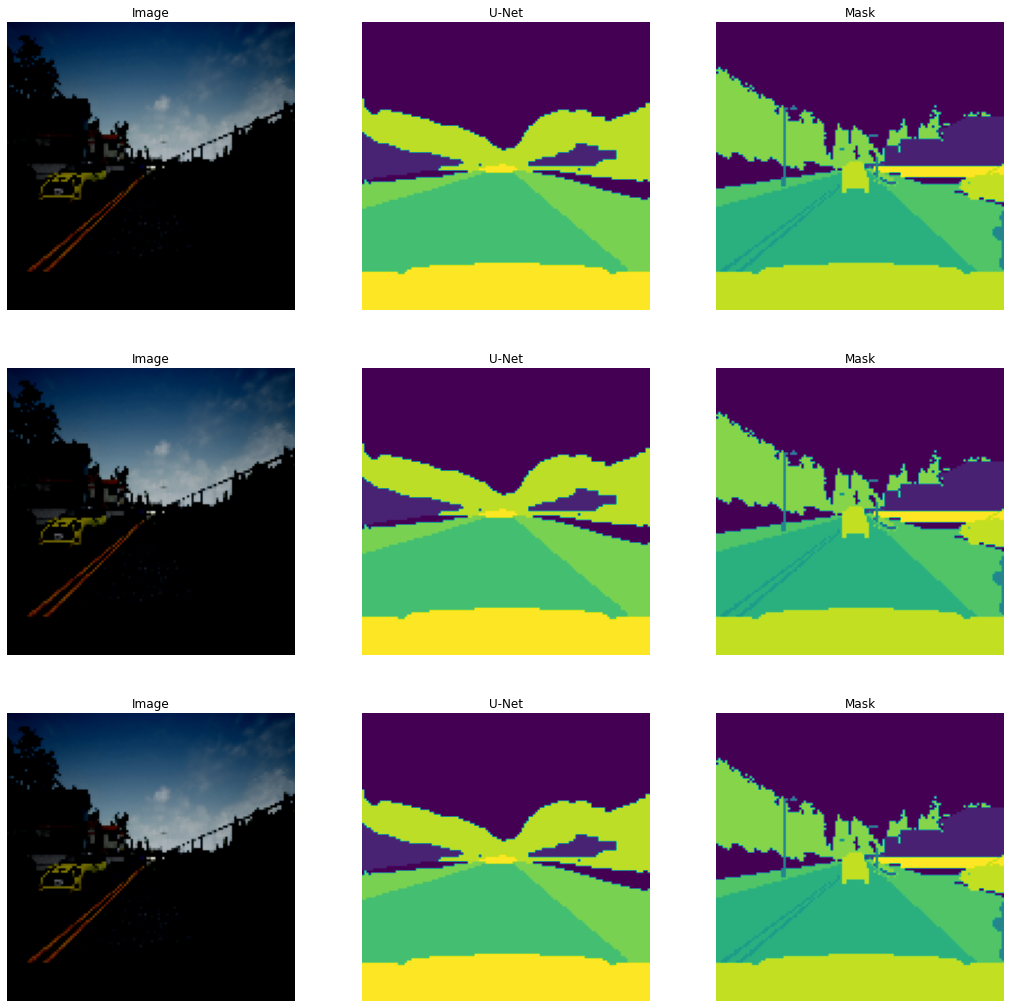

In [13]:
#%%
for x,y in test_batch:
    x = x.to(DEVICE)
    fig , ax =  plt.subplots(3, 3, figsize=(18, 18))
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(softmax(model(x)),axis=1).to('cpu')
    img1 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds1 = np.array(preds[0,:,:])
    mask1 = np.array(y[0,:,:])
    img2 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds2 = np.array(preds[0,:,:])
    mask2 = np.array(y[0,:,:])
    img3 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds3 = np.array(preds[0,:,:])
    mask3 = np.array(y[0,:,:])
    ax[0,0].set_title('Image')
    ax[0,1].set_title('U-Net')
    ax[0,2].set_title('Mask')
    ax[1,0].set_title('Image')
    ax[1,1].set_title('U-Net')
    ax[1,2].set_title('Mask')
    ax[2,0].set_title('Image')
    ax[2,1].set_title('U-Net')
    ax[2,2].set_title('Mask')
    ax[0][0].axis("off")
    ax[1][0].axis("off")
    ax[2][0].axis("off")
    ax[0][1].axis("off")
    ax[1][1].axis("off")
    ax[2][1].axis("off")
    ax[0][2].axis("off")
    ax[1][2].axis("off")
    ax[2][2].axis("off")
    ax[0][0].imshow(img1)
    ax[0][1].imshow(preds1)
    ax[0][2].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(preds2)
    ax[1][2].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(preds3)
    ax[2][2].imshow(mask3)   
    break




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


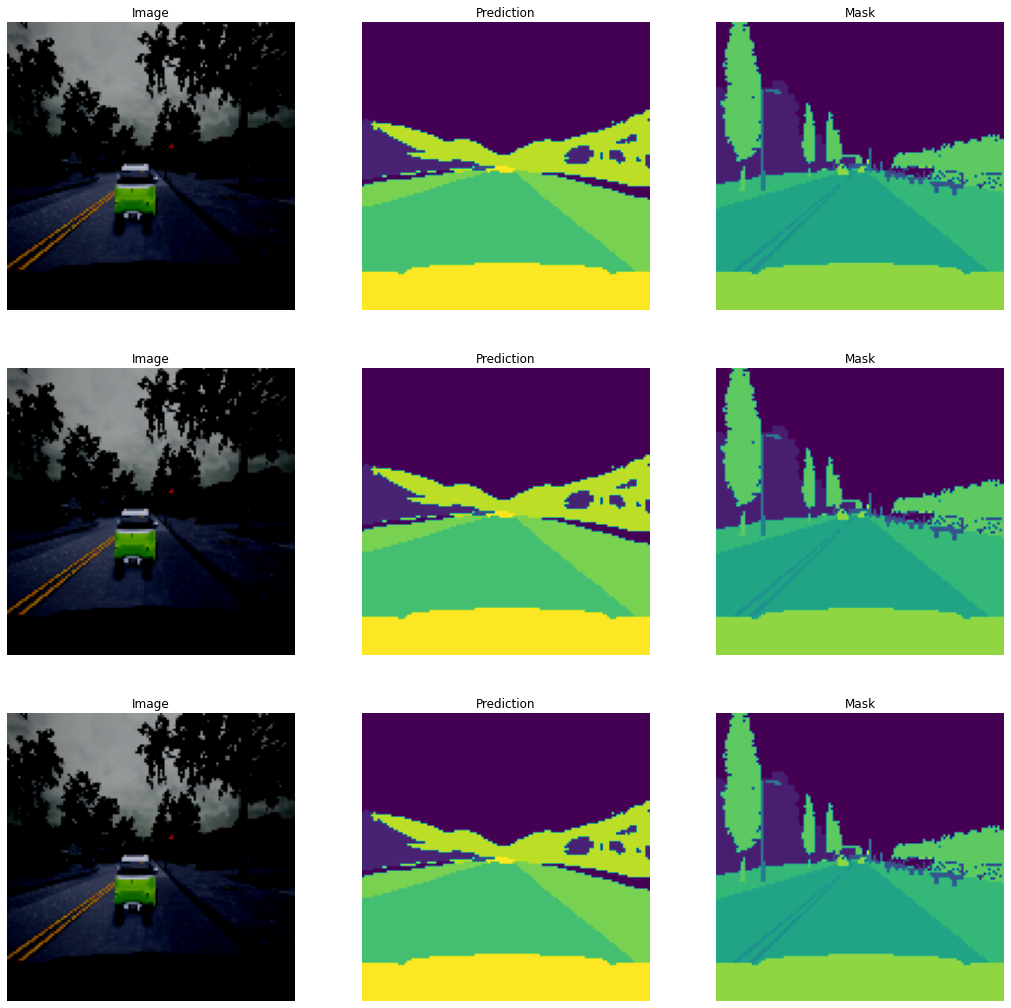